Evaluating performance for standard vs segmented INT8 run

In [2]:
%cd ..

/Users/matthewding/Documents/GitHub/pi-llama


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt

from exputils import *

In [4]:
# should now be in parent dir
if "logs" not in os.listdir('.'):
    raise Exception("Incorrect working directory. Please double check.")

In [5]:
norm_run = "outq80-final.txt"
seg_run = "outq80-seq-1.txt"

In [6]:
# some of our data's output format doesn't match because we changed the profiler. this function modifies our parser fot he anomalies
def parse_logs_seg_bespoke(logs):
    num_tokens = len(re.findall(r"generated token", " ".join(logs))) + 1 # +1 because got truncated
    time_data = np.zeros((num_tokens, NUM_LAYERS), dtype=np.uint64)
    cycle_data = np.zeros((num_tokens, NUM_LAYERS), dtype=np.uint64)

    curr_line_idx, curr_token_idx = -1, 0

    # always discard first read per token
    last_cycle, last_time = None, None
    # flag to avoid parsing final time print
    in_cycle = False
    uint64_max = np.uint64(2**64 - 1)  # overflow

    for line in logs:
        if "generated token" in line:
            curr_token_idx += 1
            curr_line_idx = -1  # off by one
            in_cycle = False
        # scuffed: "Layer: %d: " (e.g., "Layer: 0: ")
        if "Memory used for layer" in line:
            in_cycle = True
            curr_line_idx += 1
        elif in_cycle and "Elapsed cycles" in line:
            cycle = np.uint64(re.findall(r"Elapsed cycles: (\d+)", line)[0])
            if last_cycle is not None:
                cycle_diff = (
                    cycle - last_cycle
                    if cycle > last_cycle
                    else uint64_max - last_cycle + cycle
                )
                cycle_data[curr_token_idx, curr_line_idx] = cycle_diff
            last_cycle = cycle
        elif in_cycle and "Elapsed time" in line:
            time = np.uint64(re.findall(r"Elapsed time: (\d+) us", line)[0])
            if last_time is not None:
                time_diff = (
                    time - last_time
                    if time > last_time
                    else uint64_max - last_time + time
                )
                time_data[curr_token_idx, curr_line_idx] = time_diff
            last_time = time

    return time_data, cycle_data, num_tokens

In [7]:
with open("logs/" + seg_run) as f:
    norm_logs = f.readlines()
    seg_time_data, seg_cycle_data, seg_num_tokens = parse_logs_seg_bespoke(norm_logs)
    # first token is garbage so just discard first generated token
    seg_time_data = seg_time_data[1:]
    seg_cycle_data = seg_cycle_data[1:]

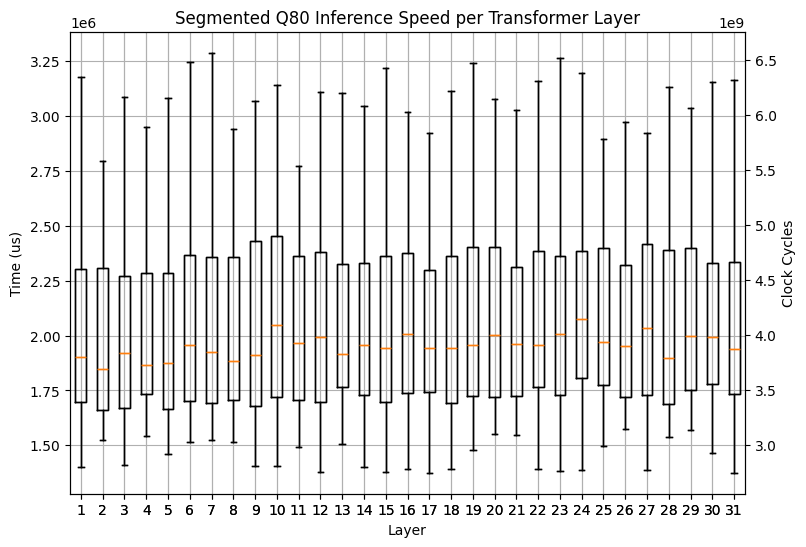

In [8]:
fig, ax1 = plt.subplots(figsize=(10, 6))

box1 = ax1.boxplot(seg_time_data[:, 1:], showfliers=False)
ax1.set_xlabel("Layer")
ax1.set_ylabel("Time (us)")
ax1.set_xticks(np.arange(1, seg_time_data.shape[1]))
ax1.grid(True)

ax2 = ax1.twinx()

box2 = ax2.boxplot(seg_cycle_data[:, 1:], showfliers=False)
ax2.set_ylabel("Clock Cycles")

fig.subplots_adjust(right=0.8)

plt.title("Segmented Q80 Inference Speed per Transformer Layer")

plt.show()

In [9]:
q80_time_data, q80_cycle_data, q80_num_tokens = parse_logs_for_file(norm_run)

Text(0.5, 1.0, 'Q80 Forward Iteratively Loading Weights')

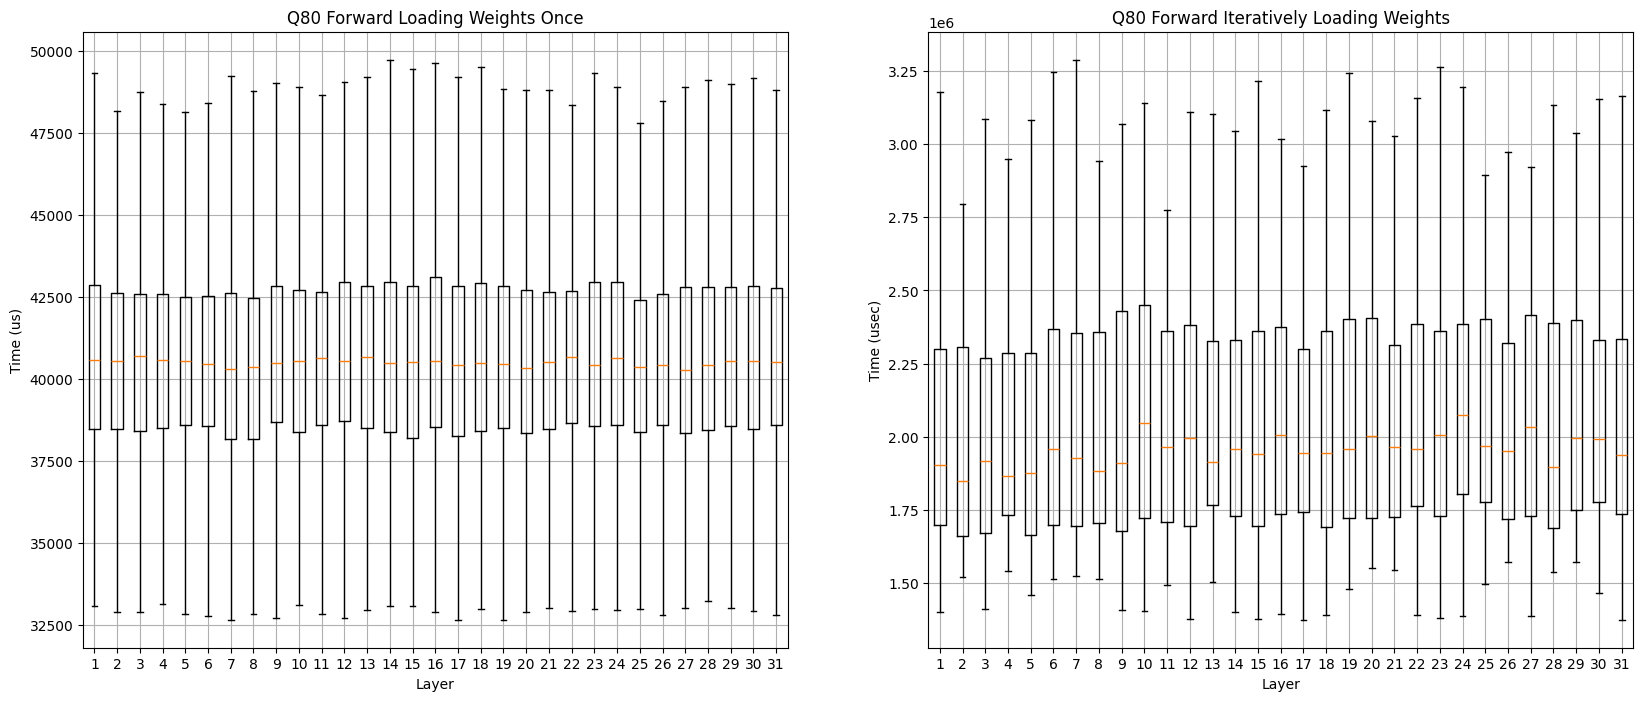

In [10]:
fig, ax1 = plt.subplots(1, 2, figsize=(20, 8))

box2 = ax1[0].boxplot(q80_time_data[:, 1:], showfliers=False)
ax1[0].set_xlabel("Layer")
ax1[0].set_ylabel("Time (us)")
ax1[0].set_xticks(np.arange(1, q80_time_data.shape[1]))
ax1[0].grid(True)
ax1[0].set_title("Q80 Forward Loading Weights Once")

box1 = ax1[1].boxplot(seg_time_data[:, 1:], showfliers=False)
ax1[1].set_ylabel("Time (usec)")
ax1[1].set_xlabel("Layer")
ax1[1].set_xticks(np.arange(1, q80_time_data.shape[1]))
ax1[1].grid(True)
ax1[1].set_title("Q80 Forward Iteratively Loading Weights")

In [11]:
TICK_EVERY = 4

[Text(0, 0, '0'),
 Text(8, 0, '8'),
 Text(16, 0, '16'),
 Text(24, 0, '24'),
 Text(32, 0, '32'),
 Text(40, 0, '40'),
 Text(48, 0, '48'),
 Text(56, 0, '56'),
 Text(64, 0, '64'),
 Text(72, 0, '72'),
 Text(80, 0, '80')]

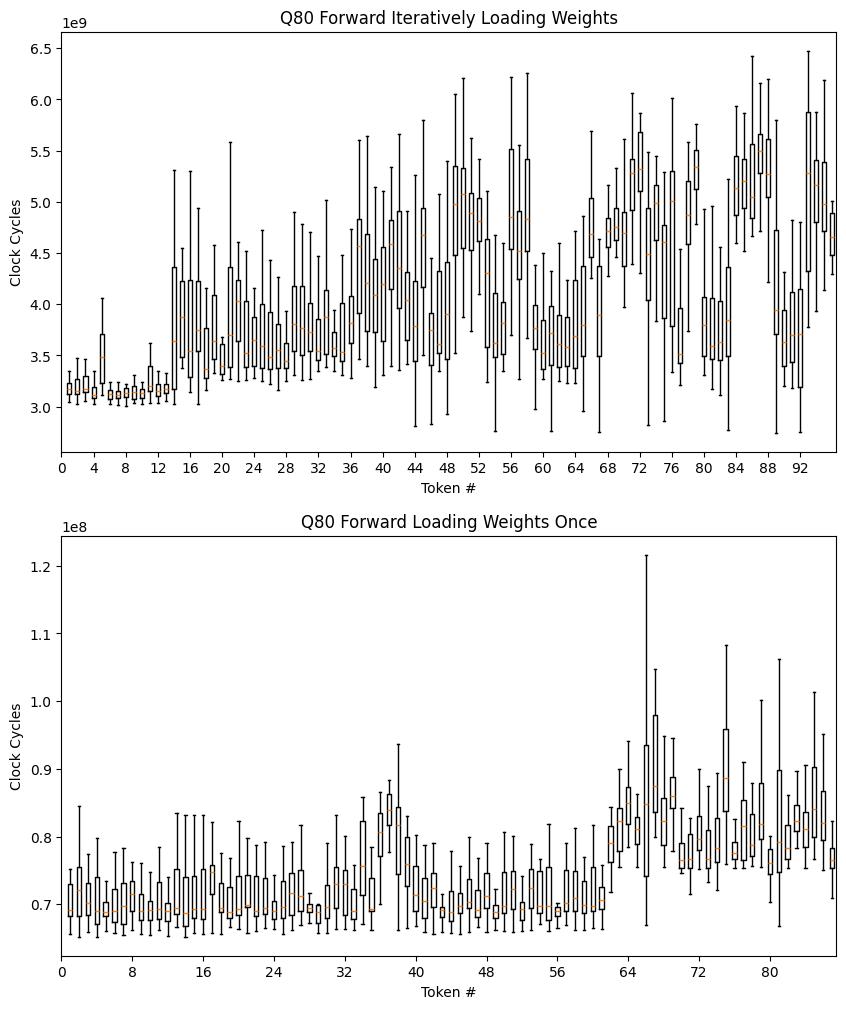

In [12]:
fig, ax1 = plt.subplots(2, 1, figsize=(10, 12))

box1 = ax1[0].boxplot(seg_cycle_data[:, 1:].T, showfliers=False)
ax1[0].set_ylabel("Clock Cycles")
ax1[0].set_xlabel("Token #")
num_tokens = seg_time_data.shape[0] - 1
tick_locations = range(0, num_tokens + 1, TICK_EVERY)
tick_labels = [str(i) for i in tick_locations]
ax1[0].set_title("Q80 Forward Iteratively Loading Weights")

# take only 92 samples
q80_cycle_data = q80_cycle_data[5:92, :]
ax1[0].set_xticks(tick_locations)
ax1[0].set_xticklabels(tick_labels)

box2 = ax1[1].boxplot(q80_cycle_data[:, 1:].T, showfliers=False)
ax1[1].set_xlabel("Token #")
ax1[1].set_ylabel("Clock Cycles")
num_tokens = q80_cycle_data.shape[0] - 1
ax1[1].set_title("Q80 Forward Loading Weights Once")

tick_locations = range(0, num_tokens + 1, TICK_EVERY * 2)
tick_labels = [str(i) for i in tick_locations]

ax1[1].set_xticks(tick_locations)
ax1[1].set_xticklabels(tick_labels)

Text(0.5, 1.0, 'Q80 Forward Iteratively Loading Weights')

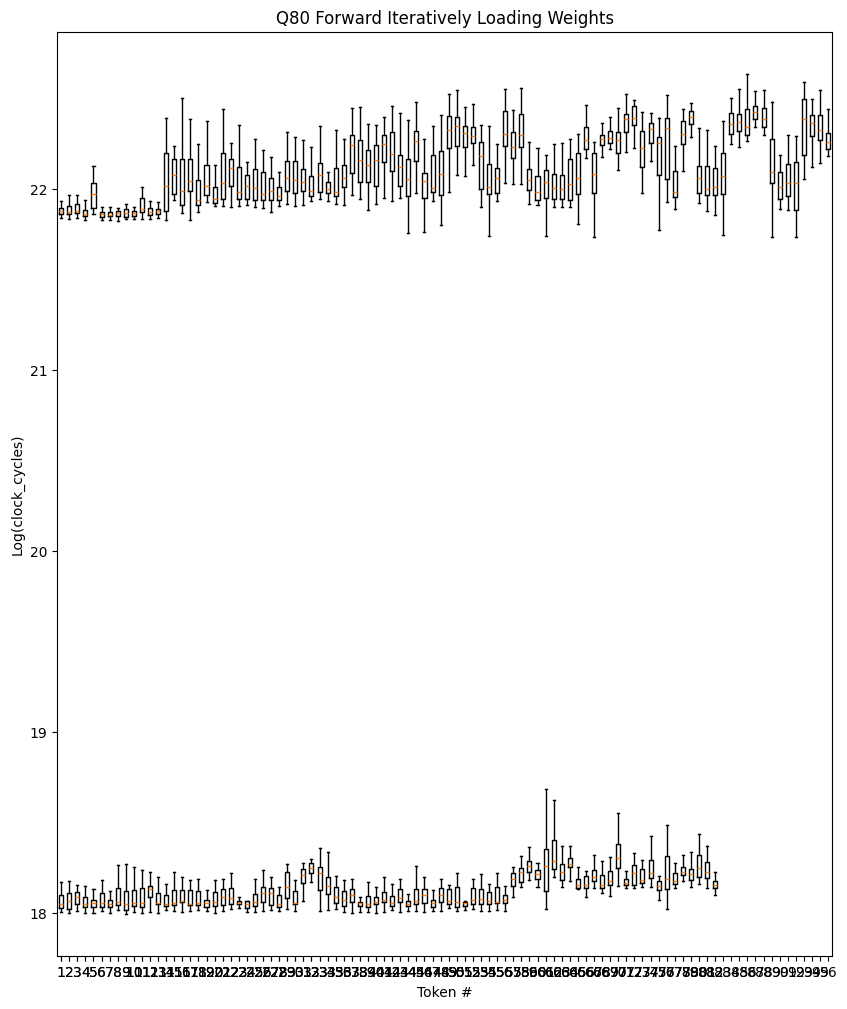

In [13]:
fig, ax1 = plt.subplots(1, 1, figsize=(10, 12))

q80_cycle_data = q80_cycle_data[5:92, :]

box1 = ax1.boxplot(np.log(seg_cycle_data[:, 1:].T), showfliers=False)
box2 = ax1.boxplot(np.log(q80_cycle_data[:, 1:].T), showfliers=False)
ax1.set_ylabel("Log(clock_cycles)")
ax1.set_xlabel("Token #")
num_tokens = seg_time_data.shape[0] - 1
tick_locations = range(0, num_tokens + 1, TICK_EVERY)
tick_labels = [str(i) for i in tick_locations]
ax1.set_title("Q80 Forward Iteratively Loading Weights")